In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from funciones_aux import imprimir_resultados, guardar_resultado_en_csv, reemplazar_no, RUTA_TRAIN, RUTA_TEST

In [19]:
df_train = pd.read_csv(RUTA_TRAIN)
df_test = pd.read_csv(RUTA_TEST)

In [20]:
df_train["sentimiento"] = df_train["sentimiento"].map({"positivo": 1, "negativo": 0})

In [21]:
RUTA_GUARDADO = "XGB.csv"

In [22]:
df_train = reemplazar_no(df_train)
df_test = reemplazar_no(df_test)

In [23]:
df_train["review_es"], df_test["review_es"] = df_train["review_es"].str.lower(), df_test["review_es"].str.lower()

In [24]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        48182 non-null  int64 
 1   ID                48182 non-null  int64 
 2   review_es         48182 non-null  object
 3   sentimiento       48182 non-null  int64 
 4   idioma_detectado  48182 non-null  object
dtypes: int64(3), object(2)
memory usage: 1.8+ MB


Buscamos si existen reseñas en otro idioma que no sean español con la biblioteca langdetect

Aqui ya observamos que el dataset no contiene nulos

In [25]:
df_train_train, df_train_test = train_test_split(df_train, test_size=0.5, random_state=33)

In [26]:
x_train, y_train, x_test_, y_test_ = df_train_train["review_es"], df_train_train["sentimiento"], df_train_test["review_es"], df_train_test["sentimiento"]

In [27]:
x_test = df_test["review_es"]

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

In [30]:
def imprimir_resultados(y, y_pred):

    labels = [0, 1]

    f1 = f1_score(y, y_pred, pos_label=0, labels=labels)
    precision = precision_score(y, y_pred, pos_label=0, labels=labels)
    recall = recall_score(y, y_pred, pos_label=0, labels=labels)
    accuracy = accuracy_score(y, y_pred)

    cm = confusion_matrix(y_test_, y_pred)

    ConfusionMatrixDisplay(confusion_matrix=cm).plot()

    print(f"F1: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Accuracy: {accuracy}")

In [31]:
def guardar_resultado_en_csv(prediccion):

    df_predicciones = pd.DataFrame({"ID": df_test["ID"], "prediccion": prediccion})

    df_predicciones.to_csv(RUTA_GUARDADO, header=["ID", "sentimiento"], index=False)

In [32]:
vectorizer = CountVectorizer()
x_train_vec = vectorizer.fit_transform(x_train)
x_test_vec = vectorizer.transform(x_test_)

In [33]:
def func_classif(param_distributions, cv, scoring, estimator, n_iter):
  randomcv = RandomizedSearchCV(estimator=estimator,
                                param_distributions = param_distributions,
                                scoring=scoring,
                                cv=cv,
                                n_jobs = -1,
                                n_iter=n_iter,
                                random_state=33)

  randomcv.fit(x_train_vec, y_train)

  return randomcv

In [34]:
n_iter = 5

param_distributions = {
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
    "n_estimators": [100, 200, 300]
    }

cv = StratifiedKFold(n_splits=5)

scoring = "accuracy"

estimator = XGBClassifier(random_state=33)

randomcv = func_classif(param_distributions, cv, scoring, estimator, n_iter)

In [35]:
best_params_xgboost = randomcv.best_params_

In [36]:
print(best_params_xgboost)

{'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2}


In [37]:
best_xgboost = XGBClassifier(learning_rate=0.3,
                        n_estimators=250,
                        max_depth=4)

In [38]:
best_xgboost.fit(x_train_vec, y_train)

y_pred = best_xgboost.predict(x_test_vec)

F1: 0.852763312615488
Precision: 0.8636440966315073
Recall: 0.8421532846715328
Accuracy: 0.8544684737038728


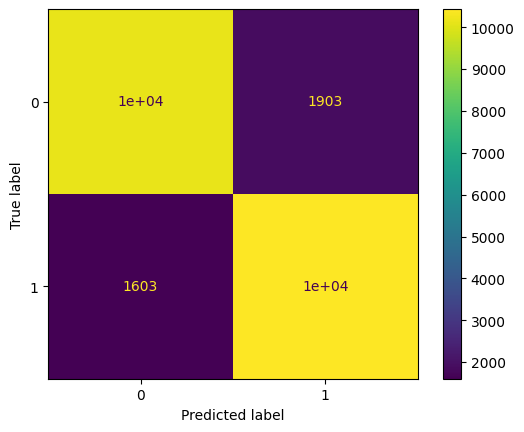

In [39]:
imprimir_resultados(y_test_, y_pred)

In [40]:
y_pred_ = best_xgboost.predict(vectorizer.transform(x_test))

In [41]:
y_pred_ = np.where(y_pred_ == 0, "negativo", "positivo")

In [42]:
guardar_resultado_en_csv(y_pred_)

In [43]:
## Testeo

In [44]:
pd.DataFrame(y_pred, columns=["Etiqueta_Predicha"])
pd.DataFrame({"review_es": x_test})
pd.DataFrame({"review_es": y_test_})


,review_es
32699,1
29345,1
24750,0
25119,1
40318,0
...,...
14729,1
23809,0
38044,1
26007,1


In [45]:
a = pd.DataFrame({"review_es": x_test_})
a.reset_index(drop=True, inplace=True)

In [46]:
b = pd.DataFrame({"sentimiento": y_test_})
b.reset_index(drop=True, inplace=True)

In [47]:
c = pd.DataFrame(y_pred, columns=["Prediccion"])
c.reset_index(drop=True, inplace=True)

In [48]:
df_resultado = pd.concat([a, b, c], axis=1)

In [49]:
df_resultado_filtro = df_resultado[df_resultado["sentimiento"] != df_resultado["Prediccion"]]

In [50]:
df_resultado_filtro

,review_es,sentimiento,Prediccion
8,vi a estabasada en los comentarios muy favorab...,0,1
20,estaes una bondad tan cursi. un grupo de perso...,1,0
26,hay una necesidad de este tipo de entretenimie...,1,0
27,"cuando la versión magistral de la ""cosa"" de jo...",1,0
45,gordon pasa por encima de la manera típica de ...,0,1
...,...,...,...
24051,"""alexander nevsky"" marcó el marcado director s...",1,0
24065,"cuando comencé a mirar, pensé que estaba viend...",1,0
24067,acabo de ver esto en el festival internacional...,1,0
24083,"aparentemente, estoy nadando contra la marea d...",0,1
